In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from cv2.xphoto import createSimpleWB

### White Balance

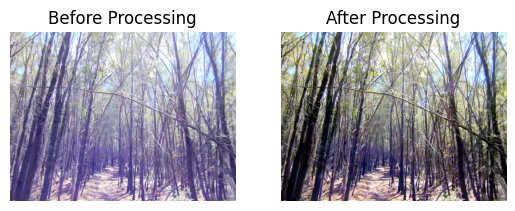

In [2]:
imagePath = "./dataset/image/"
labelPath = "./dataset/indexLabel/"
humanLabelPath = "./dataset/label/"
# filenames = [f for f in os.listdir(imagePath) if os.path.isfile(os.path.join(imagePath, f))]
filenames = ['1639441226-382639988.png']

for file in filenames:
    src = cv2.imread(imagePath + file)

    sw = createSimpleWB()

    result = sw.balanceWhite(src)

    src_rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite(file, result)
    plt.subplot(1, 2, 1)
    plt.title('Before Processing')
    plt.imshow(src_rgb)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('After Processing')
    plt.imshow(result_rgb)
    plt.axis('off')

    plt.show()

### Flares, Shadow and Lighting conditions

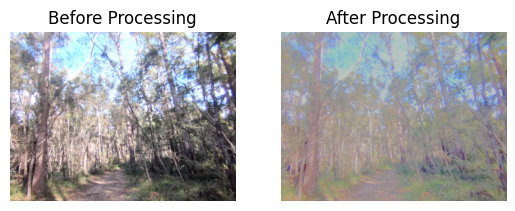

In [3]:
def compute_average_median(image, mask):
    mask = mask.astype(np.uint8)

    masked_values = image[mask == 1]
    
    average_value = np.mean(masked_values)
    median_value = np.median(masked_values)
    
    return average_value, median_value

def adjust_brightness_contrast(image, contrast=0, brightness=0):
    image = image.astype(np.float32)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    if brightness != 0:
        lim = 255 - brightness
        v[v > lim] = 255
        v[v <= lim] += brightness
    
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        v = cv2.addWeighted(v, f, v, 0, 127*(1-f))

    hsv = cv2.merge((h, s, v))
    adjusted_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    adjusted_image = (adjusted_image).astype(np.uint8)
    
    return adjusted_image


def adjust_brightness(image, alpha=0.7):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixel_values = gray.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    kmeans = KMeans(n_clusters=9, random_state=42)
    kmeans.fit(pixel_values)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    intensities = np.mean(centers, axis=1)
    sorted_indices = np.argsort(intensities)

    sorted_labels = np.zeros_like(labels)
    for i, idx in enumerate(sorted_indices):
        sorted_labels[labels == idx] = i

    sorted_centers = centers[sorted_indices]
    segmented_image = sorted_centers[sorted_labels.flatten()]
    segmented_image = segmented_image.reshape(gray.shape)
    segmented_image = np.uint8(segmented_image)
    
    mask0 = sorted_labels.reshape(gray.shape[:2])
    mask1 = np.where(mask0 == 0, 1, 0).astype(np.float32)
    mask2 = np.where(mask0 == 1, 1, 0).astype(np.float32)
    mask3 = np.where(mask0 == 2, 1, 0).astype(np.float32)
    mask4 = np.where(mask0 == 3, 1, 0).astype(np.float32)
    mask5 = np.where(mask0 == 4, 1, 0).astype(np.float32)
    mask6 = np.where(mask0 == 5, 1, 0).astype(np.float32)
    mask7 = np.where(mask0 == 6, 1, 0).astype(np.float32)
    mask8 = np.where(mask0 == 7, 1, 0).astype(np.float32)
    mask9 = np.where(mask0 == 8, 1, 0).astype(np.float32)

    smooth_mask1 = cv2.GaussianBlur(mask1, (1, 1), 10)
    smooth_mask2 = cv2.GaussianBlur(mask2, (1, 1), 10)
    smooth_mask3 = cv2.GaussianBlur(mask3, (1, 1), 10)
    smooth_mask4 = cv2.GaussianBlur(mask4, (3, 3), 10)
    smooth_mask5 = cv2.GaussianBlur(mask5, (3, 3), 10)
    smooth_mask6 = cv2.GaussianBlur(mask6, (3, 3), 10)
    smooth_mask7 = cv2.GaussianBlur(mask7, (3, 3), 10)
    smooth_mask8 = cv2.GaussianBlur(mask8, (3, 3), 10)
    smooth_mask9 = cv2.GaussianBlur(mask9, (3, 3), 10)

    smooth_mask_sum =smooth_mask1 + smooth_mask2 + smooth_mask3 + smooth_mask4 + smooth_mask5 + smooth_mask6 + smooth_mask7 + smooth_mask8 + smooth_mask9
    smooth_mask2 /= smooth_mask_sum
    smooth_mask3 /= smooth_mask_sum
    smooth_mask4 /= smooth_mask_sum
    smooth_mask5 /= smooth_mask_sum
    smooth_mask6 /= smooth_mask_sum
    smooth_mask7 /= smooth_mask_sum
    smooth_mask8 /= smooth_mask_sum
    smooth_mask9 /= smooth_mask_sum

    average_1, median_1 = compute_average_median(image, mask1)
    average_2, median_2 = compute_average_median(image, mask2)
    average_3, median_3 = compute_average_median(image, mask3)
    average_4, median_4 = compute_average_median(image, mask4)
    average_5, median_5 = compute_average_median(image, mask5)
    average_6, median_6 = compute_average_median(image, mask6)
    average_7, median_7 = compute_average_median(image, mask7)
    average_8, median_8 = compute_average_median(image, mask8)
    average_9, median_9 = compute_average_median(image, mask9)


    adjusted_image = image.copy()
    beta = -int((average_9 - average_5)/1.5)
    # print(f"using {beta} for mask9")
    adjusted_image9 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_8 - average_5)/1.3)
    # print(f"using {beta} for mask8")
    adjusted_image8 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_7 - average_5)/1.2)
    # print(f"using {beta} for mask7")
    adjusted_image7 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_6 - average_5)/1.1)
    # print(f"using {beta} for mask6")
    adjusted_image6 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_5 - average_5))
    # print(f"using {beta} for mask5")
    adjusted_image5 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_4 - average_5)/1.1) + 1
    # print(f"using {beta} for mask4")
    adjusted_image4 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_3 - average_5)/1.2) + 2
    # print(f"using {beta} for mask3")
    adjusted_image3 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_2 - average_5)/1.3) + 5
    # print(f"using {beta} for mask2")
    adjusted_image2 = adjust_brightness_contrast(adjusted_image, alpha, beta)

    adjusted_image = image.copy()
    beta = -int((average_1 - average_5)/1.5) + 10
    # print(f"using {beta} for mask1")
    adjusted_image1 = adjust_brightness_contrast(adjusted_image, alpha, beta)
    


    adjusted_image9 = adjusted_image9.astype(np.float32)
    adjusted_image8 = adjusted_image8.astype(np.float32)
    adjusted_image7 = adjusted_image7.astype(np.float32)
    adjusted_image6 = adjusted_image6.astype(np.float32)
    adjusted_image5 = adjusted_image5.astype(np.float32)
    adjusted_image4 = adjusted_image4.astype(np.float32)
    adjusted_image3 = adjusted_image3.astype(np.float32)
    adjusted_image2 = adjusted_image2.astype(np.float32)
    adjusted_image1 = adjusted_image1.astype(np.float32)

    smooth_mask9 = smooth_mask9.astype(np.float32)
    smooth_mask8 = smooth_mask8.astype(np.float32)
    smooth_mask7 = smooth_mask7.astype(np.float32)
    smooth_mask6 = smooth_mask6.astype(np.float32)
    smooth_mask5 = smooth_mask5.astype(np.float32)
    smooth_mask4 = smooth_mask4.astype(np.float32)
    smooth_mask3 = smooth_mask3.astype(np.float32)
    smooth_mask2 = smooth_mask2.astype(np.float32)
    smooth_mask1 = smooth_mask1.astype(np.float32)

    combined_image = (
        adjusted_image9 * smooth_mask9[..., None] +
        adjusted_image8 * smooth_mask8[..., None] +
        adjusted_image7 * smooth_mask7[..., None] +
        adjusted_image6 * smooth_mask6[..., None] +
        adjusted_image5 * smooth_mask5[..., None] +
        adjusted_image4 * smooth_mask4[..., None] +
        adjusted_image3 * smooth_mask3[..., None] +
        adjusted_image2 * smooth_mask2[..., None] +
        adjusted_image1 * smooth_mask1[..., None]
    )

    combined_image = np.clip(combined_image, 0, 255)

    combined_image = combined_image.astype(np.uint8)
    
    return combined_image

def compute_average_brightness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    pixel_values = gray.flatten()

    sorted_pixels = np.sort(pixel_values)

    num_pixels = len(sorted_pixels)
    half_index = num_pixels // 2

    darkest_pixels = sorted_pixels[:half_index]
    brightest_pixels = sorted_pixels[half_index:]

    avg_darkest_brightness = np.median(darkest_pixels)
    avg_brightest_brightness = np.median(brightest_pixels)
    avg_all_brightness = np.median(sorted_pixels)

    return avg_darkest_brightness, avg_brightest_brightness, avg_all_brightness

imagePath = "./dataset/image/"
labelPath = "./dataset/indexLabel/"
humanLabelPath = "./dataset/label/"

# filenames = [f for f in os.listdir(imagePath) if os.path.isfile(os.path.join(imagePath, f))]
filenames = ["1623371021-414172031.png"]

for file in filenames:
    image = cv2.imread(imagePath + file, cv2.IMREAD_UNCHANGED)
    image_oo = image.copy()
    image = image_oo.copy()
    avg_darkest, avg_brightest, avg_all_brightness = compute_average_brightness(image)

    sw = cv2.xphoto.createGrayworldWB()

    mask = (image[:, :, 0] < 15) & (image[:, :, 1] < 15) & (image[:, :, 2] < 15)
    mask = mask.astype(np.uint8) * 255

    image = cv2.inpaint(image, mask, 3, cv2.INPAINT_NS)
    
    image = sw.balanceWhite(image)
    image = adjust_brightness(image, 1)
    image = sw.balanceWhite(image)
    cv2.imwrite(file, image)
    plt.subplot(1, 2, 1)
    plt.title('Before Processing')
    plt.imshow(cv2.cvtColor(image_oo,cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('After Processing')
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.show()